# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Visualization tools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import utils
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Classification Grid Search

## X, y, X_test, and y_test sets

In [3]:
# Defining a function to create two PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [4]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print(X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


## Train, Test, and Validation Lagged Sets

In [17]:
# Lagging function

def lagged_matrices(n_steps, X_matrix, y_matrix):
    X_lagged=[]
    y_lagged=[]
    y_matrix=y_matrix
    for i in range(n_steps, X_matrix.shape[0]):
        lag_set=X_matrix[i-n_steps:i]
        X_lagged.append(lag_set) # We are taking the last n_input to the present time periods as the 
        # X values.
        y_lagged.append(int(y_matrix[i-1]))
    X_lagged=np.array(X_lagged) # They need to be arrays
    return X_lagged, y_lagged
    # Note, this does not include the last slice

In [18]:
## Getting our training, validation, and testing sets

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
print(len(X_test))
print(X_test[-2],y_test[-2])

# Classes, sets, and features
num_classes=2 
n_steps = 12 # How many time periods into the past we will look.
n_features = 20 # Number of PCA features

# Getting our lagged matrices
X_set, y_set=lagged_matrices(n_steps, X, y)
X_test, y_test=lagged_matrices(n_steps, X_test, y_test)

# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

# Making sure the y sets are arrays
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

print(X_train.shape) # Confirming that our shape is (n_instances, n_steps, n_features)
print(n_features)
print(len(X_test))
print(X_test[-1], y_test[-1])

4380
[12.00381295 10.53103332 -1.88724162 -1.1895646  -2.92464478  3.88806865
 -0.08486031 -1.60395372 -2.61335648 -0.14934652 -0.73597246  1.54475012
  2.13617843 -1.16336859 -0.96483306 -0.52009327 -0.53966351  0.15053102
 -0.07018671  0.08884499] 0.0
(21011, 12, 20)
20
4368
[[ 1.29014497e+01 -4.82769976e+00  1.16567171e+00 -1.03278414e+00
  -9.89632128e-01 -3.12350513e+00  2.30326310e+00  4.86487620e-01
   8.27001085e-01 -2.17862314e-01  2.42388506e-01 -1.59350172e+00
   8.17332618e-01  1.99960701e-01  3.57391978e-01 -1.07506965e+00
   6.08918077e-01  1.70929176e+00 -8.50528239e-01 -6.96586362e-01]
 [ 1.27587650e+01 -3.92373528e+00 -1.30415014e+00  2.62244585e-01
  -9.07433242e-01 -4.31326472e+00  1.32175328e+00 -1.05723272e+00
   2.66114270e+00  7.72889189e-02  1.29249292e-01 -1.27238791e+00
   9.18483991e-01 -9.12614270e-01  6.87843633e-01 -1.37176747e+00
  -9.53989514e-01  5.44160541e-01  7.67267115e-01  8.33668980e-01]
 [ 1.27754636e+01 -4.36312781e+00 -1.50245709e+00  2.5413857

## Grid Search

In [30]:
def create_lstm_model(activ_function='relu', units=50, dropout_rate=0.1, num_layers=2, 
                     optimizer='adam',learning_rate=1e-3,
                     n_steps=n_steps, n_features=n_features):
    # create model
    model = keras.Sequential()
        
    if num_layers==2:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), 
               return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))

        
    if num_layers==3:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==4:
        #Adding the First input hidden layer and the LSTM layer
        # return_sequences = True, means the output of every time step to be shared with hidden next layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, input_shape = (n_steps, n_features), return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=True))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fourth layer
        model.add(keras.layers.LSTM(units = units, activation = activ_function, return_sequences=False)) # For the final later, we don't need to return the sequences
        model.add(keras.layers.Dropout(dropout_rate))
        
    # Final layer with sigmoid for classification
    model.add(keras.layers.Dense(1, activation="sigmoid"))
        
    # Running through the optimizers
    if optimizer=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    if optimizer=='RMSprop':
        optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
        
    if optimizer=='SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
        )    
    return model

In [31]:
# Creating and compiling the model with a summary

lstm = create_lstm_model()
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 18, 50)            14200     
                                                                 
 dropout_18 (Dropout)        (None, 18, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34,451
Trainable params: 34,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Optimize the model with grid search

# Grid search parameters
n_epochs_cv = 20 # Number of epochs for our grid search
n_cv = 3 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(build_fn=create_lstm_model, verbose=1)

# Define parameters and values for grid search to check in our model
param_grid = {
    # Model parameters
    'activ_function':['relu', 'tanh', 'sigmoid'],
    'units':[256, 512, 1024],
    'dropout_rate':[0.1],
    'num_layers':[2, 3, 4],
    'optimizer':['adam', 'RMSProp', 'SGD'],
    'learning_rate':[1e-3, 1e-5, 1e-7],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

<ipython-input-9-c79acf7327de>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_lstm_model, verbose=1)


Epoch 1/20
194/438 [============>.................] - ETA: 53s - loss: 0.7017 - accuracy: 0.4979

KeyboardInterrupt: 

In [ ]:
print(grid_result.best_params_)

In [ ]:
lstm_model=create_lstm_model(activ_function=grid_result.best_params_['activ_function'], 
                                            units=grid_result.best_params_['neurons'], 
                                            dropout_rate=grid_result.best_params_['dropout_rate'],
                                            num_layers=grid_result.best_params_['num_layers'],
                                            optimizer=grid_result.best_params_['optimizer'],
                          learning_rate=grid_result.best_params_['learning_rate'])

# Fitting the model
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val), verbose=0)

Dev notes: 

1/24. Having hard time getting it to learn anything. At activ_function='tanh', 
                                            units=256, 
                                            dropout_rate=0.2,
                                            num_layers=2,
                                            optimizer='adam',
                          learning_rate=1e-3)
I am getting wild overfitting. Trying it with higher dropout rate. At 0.5, it isn't learning.

activ_function='relu', 
                                            units=256, 
                                            dropout_rate=0.6,
                                            num_layers=2,
                                            optimizer='adam',
                          learning_rate=1e-3) 
Overfitting, but the val loss was going down. Thinking of increasing the epoch to see what happens.

In [33]:
lstm_model=create_lstm_model(activ_function='sigmoid', 
                                            units=1024, 
                                            dropout_rate=0.5,
                                            num_layers=2,
                                            optimizer='RMSProp',
                          learning_rate=1e-5)

# Fitting the model
history = lstm_model.fit(np.array(X_train), np.array(y_train), epochs=20,
                         validation_data=(np.array(X_val),np.array(y_val)), verbose=1)

Epoch 1/20
657/657 [==============================] - 812s 1s/step - loss: 0.7347 - accuracy: 0.5195 - val_loss: 0.7115 - val_accuracy: 0.5013
Epoch 2/20
657/657 [==============================] - 782s 1s/step - loss: 0.6917 - accuracy: 0.5365 - val_loss: 0.6854 - val_accuracy: 0.5503
Epoch 3/20
657/657 [==============================] - 804s 1s/step - loss: 0.6888 - accuracy: 0.5468 - val_loss: 0.6904 - val_accuracy: 0.5428
Epoch 4/20
657/657 [==============================] - 652s 992ms/step - loss: 0.6883 - accuracy: 0.5465 - val_loss: 0.6890 - val_accuracy: 0.5539
Epoch 5/20
657/657 [==============================] - 645s 982ms/step - loss: 0.6877 - accuracy: 0.5441 - val_loss: 0.6870 - val_accuracy: 0.5501
Epoch 6/20
657/657 [==============================] - 661s 1s/step - loss: 0.6877 - accuracy: 0.5440 - val_loss: 0.6832 - val_accuracy: 0.5537
Epoch 7/20
657/657 [==============================] - 736s 1s/step - loss: 0.6871 - accuracy: 0.5483 - val_loss: 0.6877 - val_accuracy: 

KeyboardInterrupt: 

## Model Performance

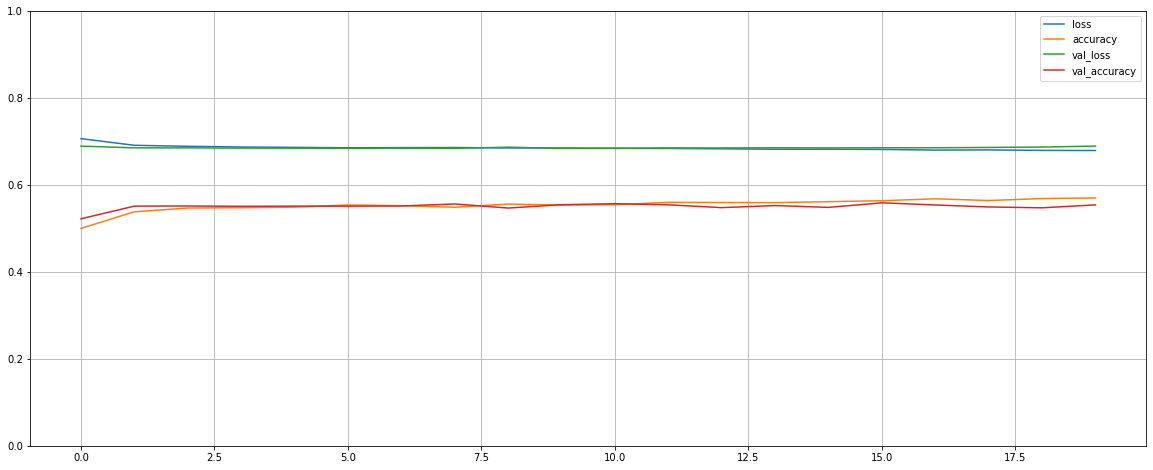

In [22]:
# Training Performance

history.history.keys()
pd.DataFrame(history.history).plot(figsize=(20, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

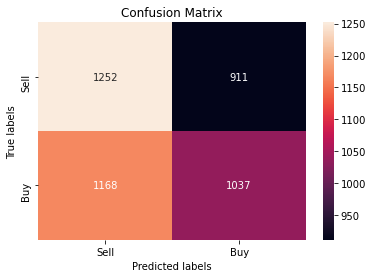

In [23]:
# Confusion Matrix

# # Performance
y_pred=lstm_model.predict(X_test) # Returns a list where every element is an array with the continuous
# value prediction
y_pred=[x[0] for x in y_pred] # Getting all the continuous value predictions from the arrays
for i in range(len(y_pred)): # Transforming the continuous value into binary labels
    if y_pred[i] <= 0.5:
        y_pred[i] = 0
    if y_pred[i] > 0.5:
        y_pred[i] = 1

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

## Saving and Reloading the Model

In [24]:
# Saving the model

lstm_model.save('Models/LSTM Class 18_2 BTC.h5')

In [ ]:
# Reloading the model

lstm_class_model=model = keras.models.load_model('Models/LSTM Class 1H BTC.h5')